<a id="sec1"></a>
# Importing data

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [32]:
df_accepted = pd.read_csv("accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15960\3656527957.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accepted = pd.read_csv("accepted_2007_to_2018Q4.csv")


(2260701, 151)


<a id="sec2"></a>

# Exploratory Data Analysis (and some initial pre-processing)

Since we are going to predict loan_status, let's take a brief closer look on it:

In [33]:
df_accepted.loan_status.value_counts()

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

for the sake of simplicity, let's consider only _Fully Paid_ and _Charged Off_ values:

In [34]:
df_accepted = df_accepted[df_accepted.loan_status.isin(
    ['Fully Paid', 'Charged Off'])]

print(df_accepted.shape)

(1345310, 151)


<Axes: xlabel='loan_status', ylabel='count'>

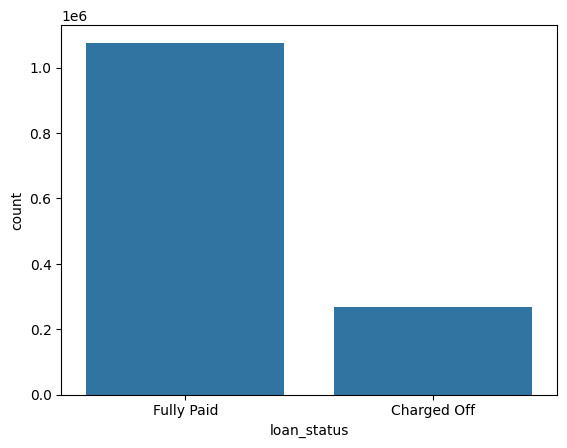

In [35]:
sns.countplot(x="loan_status", data=df_accepted)

checking now null values per columns:

In [36]:
df_accepted.isnull().sum().sort_values(ascending=False)

next_pymnt_d                                  1345310
member_id                                     1345310
orig_projected_additional_accrued_interest    1341551
hardship_start_date                           1339556
hardship_length                               1339556
                                               ...   
pub_rec                                             0
open_acc                                            0
fico_range_high                                     0
fico_range_low                                      0
id                                                  0
Length: 151, dtype: int64

wow, there is a bunch of columns almost full of missing values. Let's check the first 50 columns sorted by missing values:

In [37]:
df_accepted.isnull().sum().sort_values(ascending=False).head(50)

next_pymnt_d                                  1345310
member_id                                     1345310
orig_projected_additional_accrued_interest    1341551
hardship_start_date                           1339556
hardship_length                               1339556
hardship_type                                 1339556
hardship_reason                               1339556
hardship_status                               1339556
deferral_term                                 1339556
hardship_amount                               1339556
hardship_end_date                             1339556
payment_plan_start_date                       1339556
hardship_dpd                                  1339556
hardship_loan_status                          1339556
hardship_payoff_balance_amount                1339556
hardship_last_payment_amount                  1339556
sec_app_mths_since_last_major_derog           1338665
sec_app_revol_util                            1327008
revol_bal_joint             

let's drop these columns, as it will not contribute to our goal.

In [38]:
cols_to_drop = df_accepted.isnull().sum().sort_values(
    ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1345310, 101)

let's check again:

In [39]:
df_accepted.isnull().sum().sort_values(ascending=False).head(50)

total_bal_il                  807712
open_act_il                   807712
open_rv_12m                   807712
open_rv_24m                   807712
inq_fi                        807712
open_il_12m                   807712
open_il_24m                   807712
mths_since_last_delinq        678743
mths_since_recent_inq         174071
num_tl_120dpd_2m              117401
mo_sin_old_il_acct            105575
emp_title                      85785
emp_length                     78511
pct_tl_nvr_dlq                 67681
avg_cur_bal                    67549
mo_sin_rcnt_rev_tl_op          67528
num_rev_accts                  67528
mo_sin_old_rev_tl_op           67528
num_actv_rev_tl                67527
num_actv_bc_tl                 67527
num_il_tl                      67527
num_accts_ever_120_pd          67527
num_bc_tl                      67527
total_il_high_credit_limit     67527
num_rev_tl_bal_gt_0            67527
num_op_rev_tl                  67527
tot_cur_bal                    67527
t

maybe we can go further, and eliminate columns up to title:

In [40]:
cols_to_drop = df_accepted.isnull().sum().sort_values(
    ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1345310, 56)

for the remaining columns with missing values, let's see the missing percentage:

In [41]:
nulls = df_accepted.isnull().sum().sort_values(ascending=False)
nulls_percentage = (nulls/df_accepted.shape[0]*100)
nulls_percentage.head(15)

last_pymnt_d                  0.171931
revol_util                    0.063703
pub_rec_bankruptcies          0.051810
dti                           0.027800
chargeoff_within_12_mths      0.004163
collections_12_mths_ex_med    0.004163
last_credit_pull_d            0.004088
tax_liens                     0.002899
inq_last_6mths                0.000074
zip_code                      0.000074
delinq_amnt                   0.000000
disbursement_method           0.000000
out_prncp_inv                 0.000000
total_pymnt                   0.000000
total_pymnt_inv               0.000000
dtype: float64

Remaining columns have missing data points, but they account for less than 0.2% of the total data. 
Let's remove the rows that are missing those values in those columns with dropna():

In [42]:
df_accepted = df_accepted.dropna()
df_accepted.head

<bound method NDFrame.head of                id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0        68407277     3600.0       3600.0           3600.0   36 months   
1        68355089    24700.0      24700.0          24700.0   36 months   
2        68341763    20000.0      20000.0          20000.0   60 months   
4        68476807    10400.0      10400.0          10400.0   60 months   
5        68426831    11950.0      11950.0          11950.0   36 months   
...           ...        ...          ...              ...         ...   
2260688  89905081    18000.0      18000.0          18000.0   60 months   
2260690  88948836    29400.0      29400.0          29400.0   60 months   
2260691  89996426    32000.0      32000.0          32000.0   60 months   
2260692  90006534    16000.0      16000.0          16000.0   60 months   
2260697  88224441    24000.0      24000.0          24000.0   60 months   

         int_rate  installment grade sub_grade home_ownership  ...  \
0          

In [43]:
df_accepted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1341026 entries, 0 to 2260697
Data columns (total 56 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1341026 non-null  object 
 1   loan_amnt                   1341026 non-null  float64
 2   funded_amnt                 1341026 non-null  float64
 3   funded_amnt_inv             1341026 non-null  float64
 4   term                        1341026 non-null  object 
 5   int_rate                    1341026 non-null  float64
 6   installment                 1341026 non-null  float64
 7   grade                       1341026 non-null  object 
 8   sub_grade                   1341026 non-null  object 
 9   home_ownership              1341026 non-null  object 
 10  annual_inc                  1341026 non-null  float64
 11  verification_status         1341026 non-null  object 
 12  issue_d                     1341026 non-null  object 
 13  lo

### term

In [44]:
df_accepted['term'].value_counts(dropna=False)

term
36 months    1017398
60 months     323628
Name: count, dtype: int64

In [45]:
df_accepted['term'] = df_accepted['term'].apply(
    lambda s: np.int8(s.split()[0]))

In [46]:
df_accepted['term'].value_counts(dropna=False)

term
36    1017398
60     323628
Name: count, dtype: int64

### grade, subgrade

In [47]:
print(sorted(df_accepted['grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [48]:
print(sorted(df_accepted['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


<Axes: xlabel='grade', ylabel='count'>

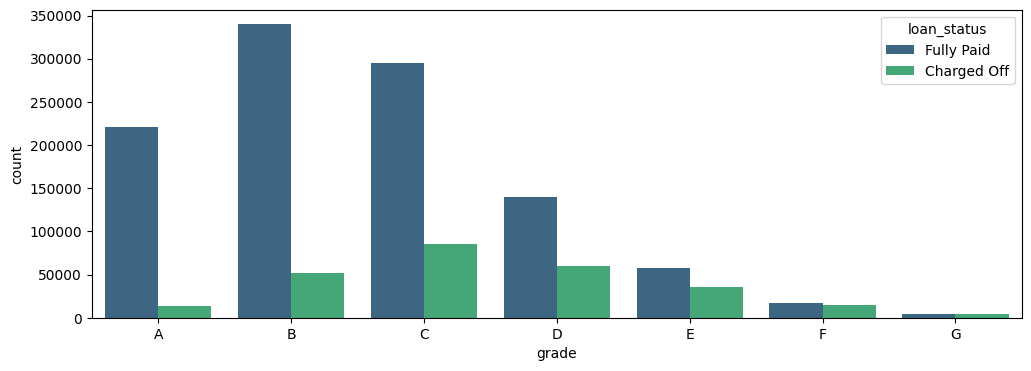

In [49]:
plt.figure(figsize=(12, 4))
sns.countplot(x='grade', data=df_accepted, hue='loan_status',
              order=sorted(df_accepted['grade'].unique()), palette='viridis')

<Axes: xlabel='sub_grade', ylabel='count'>

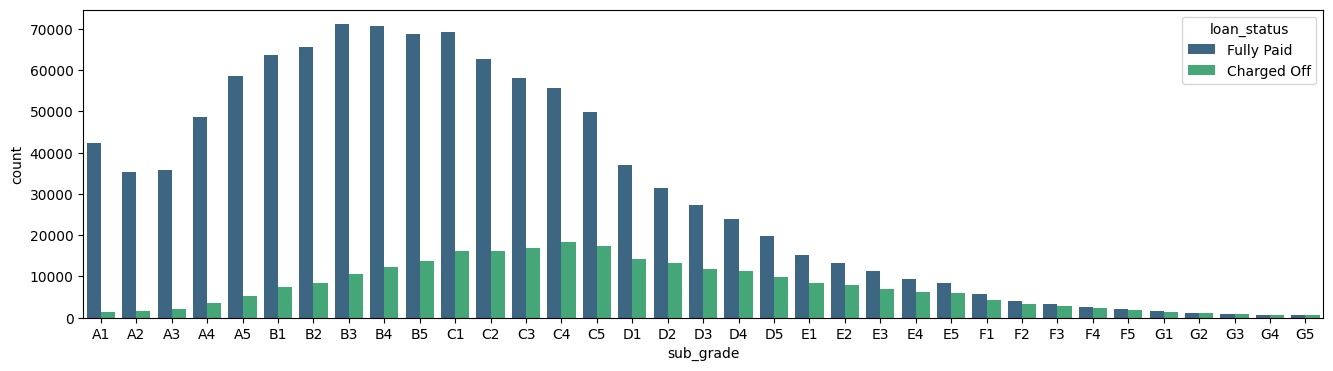

In [51]:
plt.figure(figsize=(16, 4))
subgrade_order = sorted(df_accepted['sub_grade'].unique())
sns.countplot(x='sub_grade', data=df_accepted, order=subgrade_order,
              palette='viridis', hue='loan_status')



Customers who don't pay back loan have higher grade.
Information of 'grade' is already embedded in 'sub_grade'.
Let's drop 'grade' feature.


In [52]:
df_accepted = df_accepted.drop('grade', axis=1)

In [54]:
dummies_sub_grade = pd.get_dummies(df_accepted['sub_grade'], drop_first=True)

Concat the 'dummies_sub_grade' after dropping the original feature 'sub_grade'.

In [56]:
df_accepted = pd.concat(
    [df_accepted.drop('sub_grade', axis=1), dummies_sub_grade], axis=1)

In [58]:
df_accepted.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,home_ownership,annual_inc,verification_status,...,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5
0,68407277,3600.0,3600.0,3600.0,36,13.99,123.03,MORTGAGE,55000.0,Not Verified,...,False,False,False,False,False,False,False,False,False,False
1,68355089,24700.0,24700.0,24700.0,36,11.99,820.28,MORTGAGE,65000.0,Not Verified,...,False,False,False,False,False,False,False,False,False,False
2,68341763,20000.0,20000.0,20000.0,60,10.78,432.66,MORTGAGE,63000.0,Not Verified,...,False,False,False,False,False,False,False,False,False,False
4,68476807,10400.0,10400.0,10400.0,60,22.45,289.91,MORTGAGE,104433.0,Source Verified,...,True,False,False,False,False,False,False,False,False,False
5,68426831,11950.0,11950.0,11950.0,36,13.44,405.18,RENT,34000.0,Source Verified,...,False,False,False,False,False,False,False,False,False,False


In [60]:
cols_to_drop = ['policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1341026, 87)

### home ownership

In [62]:
df_accepted['home_ownership'].value_counts()

home_ownership
MORTGAGE    663868
RENT        532493
OWN         144195
ANY            283
OTHER          142
NONE            45
Name: count, dtype: int64

In [64]:


df_accepted['home_ownership'] = df_accepted['home_ownership'].replace(
    ['NONE', 'ANY'], 'OTHER')

<Axes: xlabel='home_ownership', ylabel='count'>

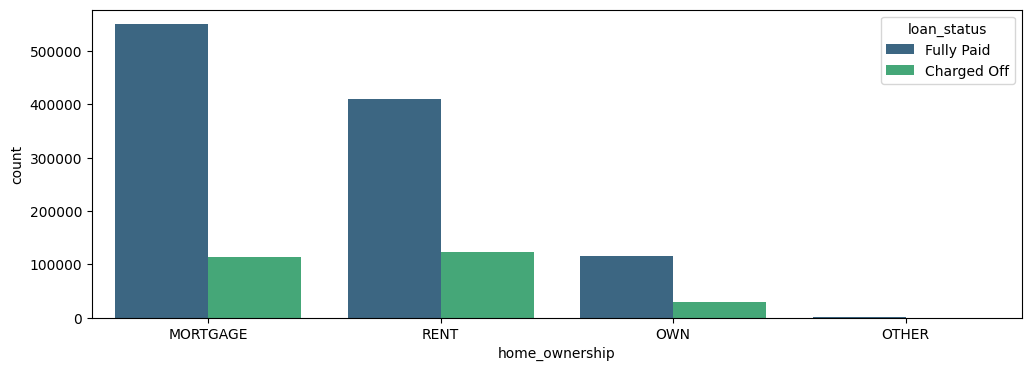

In [65]:
plt.figure(figsize=(12, 4))
sns.countplot(x='home_ownership', data=df_accepted,
              hue='loan_status', palette='viridis')

In [67]:
dummies_home_ownership = pd.get_dummies(
    df_accepted['home_ownership'], drop_first=True)



Concat the 'dummies_home_ownership' after dropping the original feature 'home_ownership'


In [68]:
df_accepted = pd.concat(
    [df_accepted.drop('home_ownership', axis=1), dummies_home_ownership], axis=1)

In [69]:
df_accepted.shape

(1341026, 89)

### addr_state

In [72]:
df_accepted['addr_state'].unique()

array(['PA', 'SD', 'IL', 'GA', 'MN', 'SC', 'RI', 'NC', 'CA', 'VA', 'AZ',
       'IN', 'MD', 'NY', 'TX', 'KS', 'NM', 'AL', 'WA', 'OH', 'LA', 'FL',
       'CO', 'MI', 'MO', 'DC', 'MA', 'WI', 'HI', 'VT', 'NJ', 'DE', 'TN',
       'NH', 'NE', 'OR', 'CT', 'AR', 'NV', 'WV', 'MT', 'WY', 'OK', 'KY',
       'MS', 'UT', 'ND', 'ME', 'AK', 'ID', 'IA'], dtype=object)

In [73]:
df_accepted['addr_state'].value_counts()

addr_state
CA    195841
TX    109829
NY    109462
FL     95269
IL     51607
NJ     48300
PA     45394
OH     43737
GA     43229
VA     37902
NC     37640
MI     35154
AZ     32607
MD     31113
MA     30865
CO     29595
WA     29088
MN     23894
IN     21672
MO     21196
TN     20325
NV     20182
CT     19678
WI     17675
AL     16555
OR     16367
SC     15937
LA     15438
KY     12806
OK     12232
KS     11208
AR     10013
UT     10001
NM      7337
HI      6738
MS      6567
NH      6433
RI      5856
WV      4871
MT      3812
DE      3768
NE      3569
DC      3459
AK      3182
WY      2917
SD      2757
VT      2645
ME      2022
ID      1681
ND      1598
IA         3
Name: count, dtype: int64

In [74]:


# drop_first will drop the first dummy column
add_state_dummies = pd.get_dummies(df_accepted['addr_state'], drop_first=True)
add_state_dummies

,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2260690,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2260691,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2260692,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Drop 'addr_state' feature and concat 'add_state_dummies' to df.

In [75]:
df_accepted = pd.concat(
    [df_accepted.drop('addr_state', axis=1), add_state_dummies], axis=1)

### annual_inc

C:\Users\Admin\AppData\Local\Temp\ipykernel_15960\155024246.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_accepted['annual_inc'], bins=100)


<Axes: ylabel='Density'>

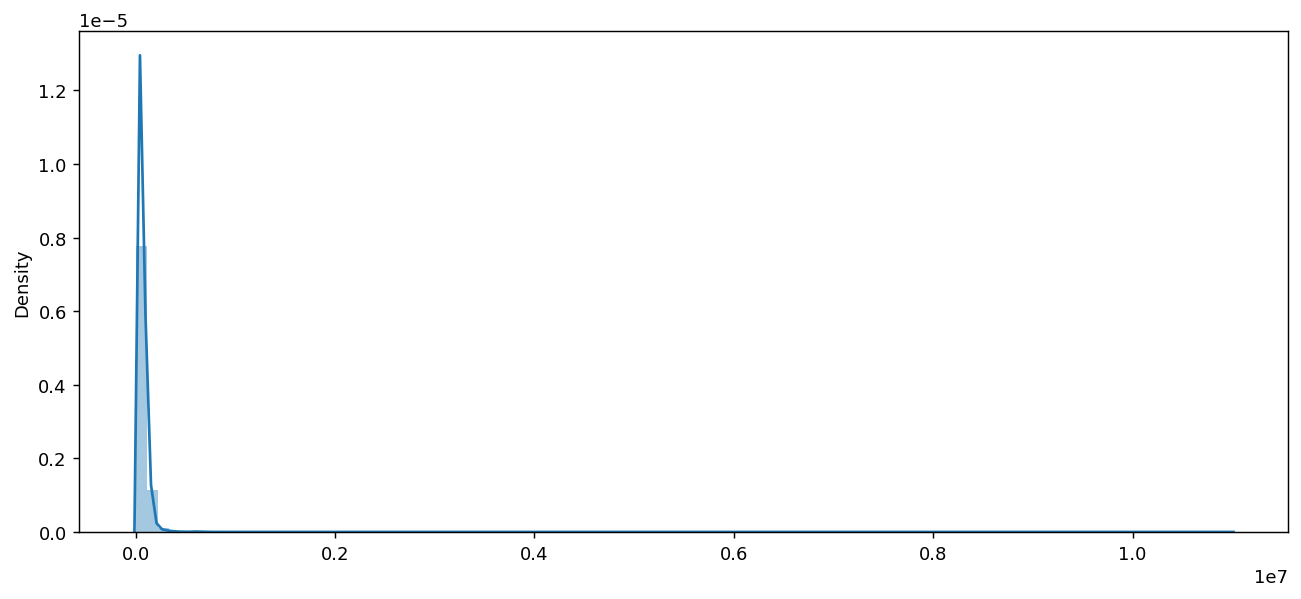

In [76]:
plt.figure(figsize=(12, 5), dpi=130)
sns.distplot(x=df_accepted['annual_inc'], bins=100)

The salary distribution is highly skewed towards right.
Let's find how many customers have annual_inc > $250000.

In [77]:
len(df_accepted[df_accepted['annual_inc'] > 250000])

13379

In [78]:
percent_of_rows_of_customers_with_annual_inc_more_than_250000 = 13447 * \
    100/len(df_accepted)

percent_of_rows_of_customers_with_annual_inc_more_than_250000

1.002739693339279



There are 13379 rows of customers with annual_inc > 250000, i.e., 1%. Since these are outliers, let's drop these rows.


In [79]:
df_accepted = df_accepted[df_accepted['annual_inc'] <= 250000]

C:\Users\Admin\AppData\Local\Temp\ipykernel_15960\3772164973.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_accepted['annual_inc'])


<Axes: ylabel='Density'>

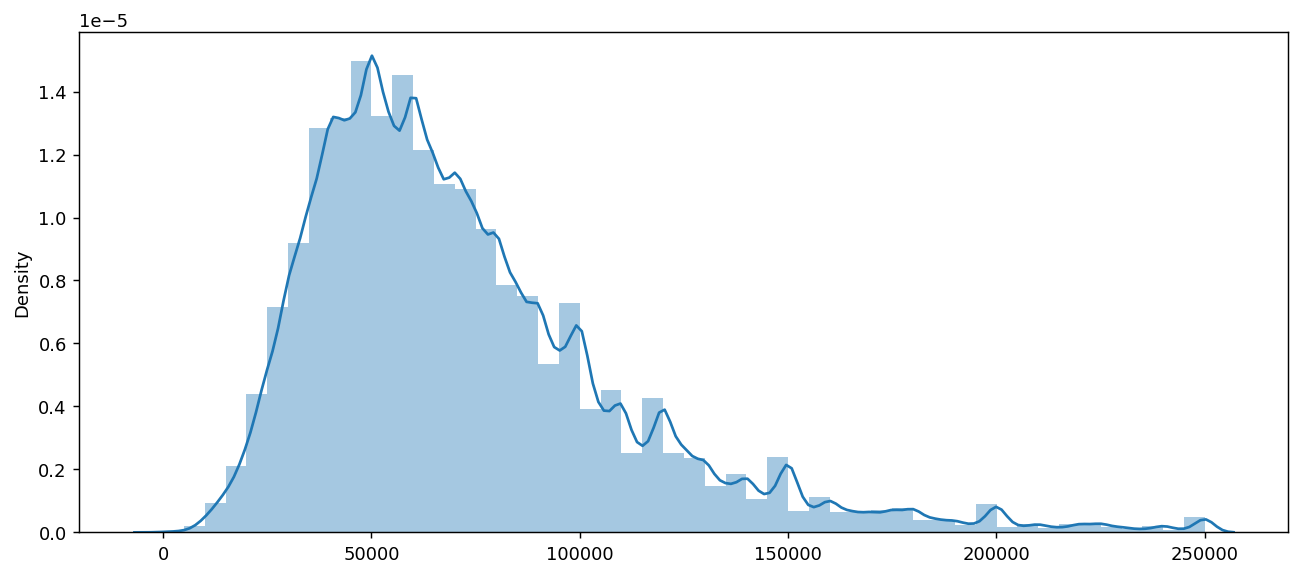

In [80]:


plt.figure(figsize=(12, 5), dpi=130)
sns.distplot(x=df_accepted['annual_inc'])

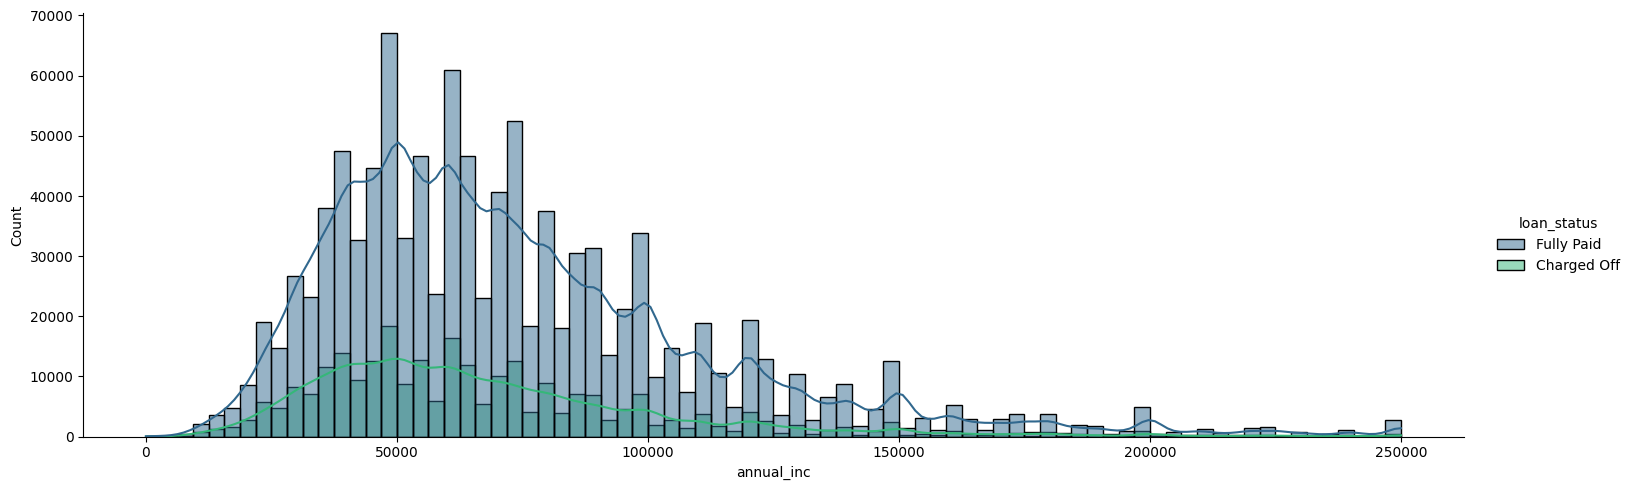

In [81]:
sns.displot(data=df_accepted, x='annual_inc', hue='loan_status',
            bins=80, height=5, aspect=3, kde=True, palette='viridis')

### earliest_cr_line

The month the borrower's earliest reported credit line was opened.

In [83]:
df_accepted['earliest_cr_line'].head()

0    Aug-2003
1    Dec-1999
2    Aug-2000
4    Jun-1998
5    Oct-1987
Name: earliest_cr_line, dtype: object

In [84]:
df_accepted['earliest_cr_line'] = df_accepted['earliest_cr_line'].apply(
    lambda date: int(date[-4:]))

In [86]:
df_accepted['earliest_cr_line'].head()

0    2003
1    1999
2    2000
4    1998
5    1987
Name: earliest_cr_line, dtype: int64

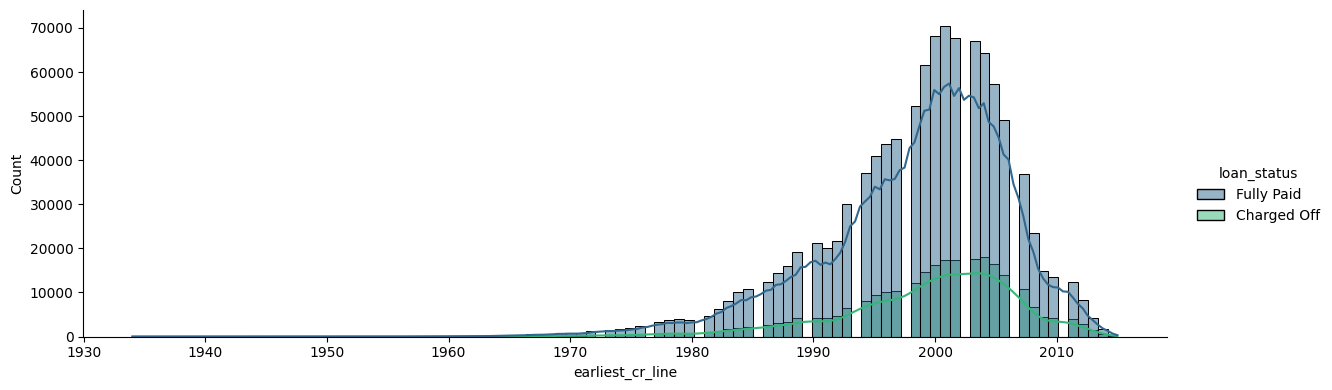

In [87]:
sns.displot(data=df_accepted, x='earliest_cr_line', hue='loan_status',
            bins=100, height=4, aspect=3, kde=True, palette='viridis')

In [88]:
df_accepted.groupby('loan_status')['earliest_cr_line'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,264163.0,1999.372217,7.567218,1944.0,1996.0,2001.0,2004.0,2015.0
Fully Paid,1063484.0,1998.572648,7.589780,1934.0,1995.0,2000.0,2004.0,2015.0




Mean earliest_cr_line for customers who fully paid the loan was approx. 1 year before the customers who did not pay the loan.


### fico_range_high and fico_range_low

In [92]:
df_accepted['fico_range_high'].head()

0    679.0
1    719.0
2    699.0
4    699.0
5    694.0
Name: fico_range_high, dtype: float64

In [93]:
df_accepted['fico_range_low'].head()

0    675.0
1    715.0
2    695.0
4    695.0
5    690.0
Name: fico_range_low, dtype: float64

It's similar

In [94]:
df_accepted['fico'] = (df_accepted['fico_range_high'] +
                       df_accepted['fico_range_low']) / 2
df_accepted['fico']

0          677.0
1          717.0
2          697.0
4          697.0
5          692.0
           ...  
2260688    737.0
2260690    707.0
2260691    737.0
2260692    667.0
2260697    662.0
Name: fico, Length: 1327647, dtype: float64

In [95]:
df_accepted = df_accepted.drop(['fico_range_high', 'fico_range_low'], axis=1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15960\4020343754.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_accepted['fico'], bins=100)


<Axes: ylabel='Density'>

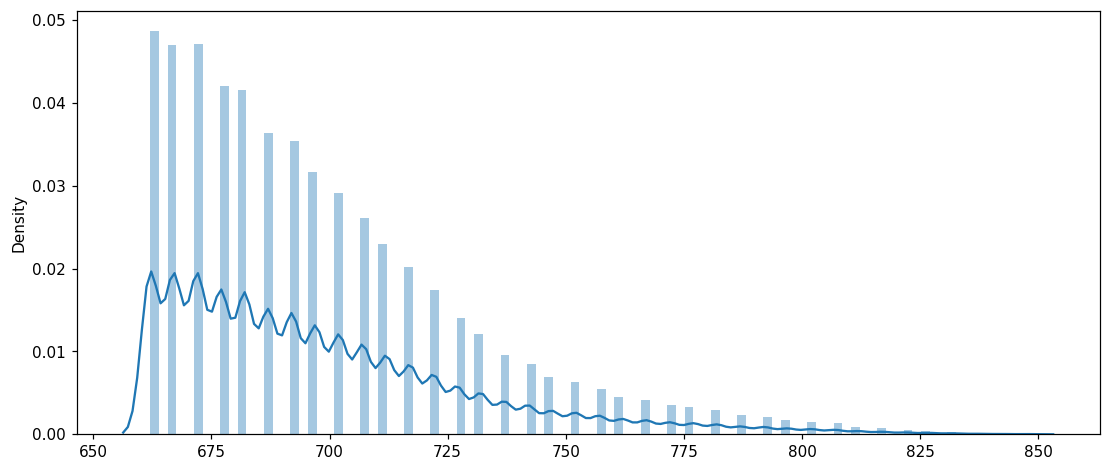

In [96]:
plt.figure(figsize=(12, 5), dpi=110)
sns.distplot(x=df_accepted['fico'], bins=100)



Check distribution of fico score of customers who Fully Paid the loan and customers who did not.


<Figure size 6000x2100 with 0 Axes>

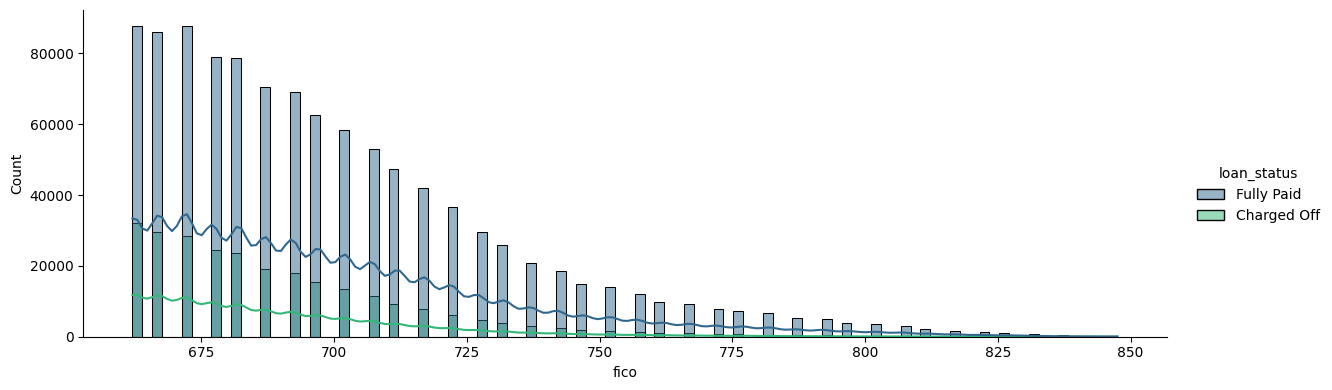

In [98]:
plt.figure(figsize=(20, 7), dpi=300)
sns.displot(data=df_accepted, x='fico', hue='loan_status',
            bins=100, height=4, aspect=3, kde=True, palette='viridis')

### application_type

In [99]:
df_accepted['application_type'].value_counts()

application_type
Individual    1302459
Joint App       25188
Name: count, dtype: int64

<Axes: xlabel='application_type', ylabel='count'>

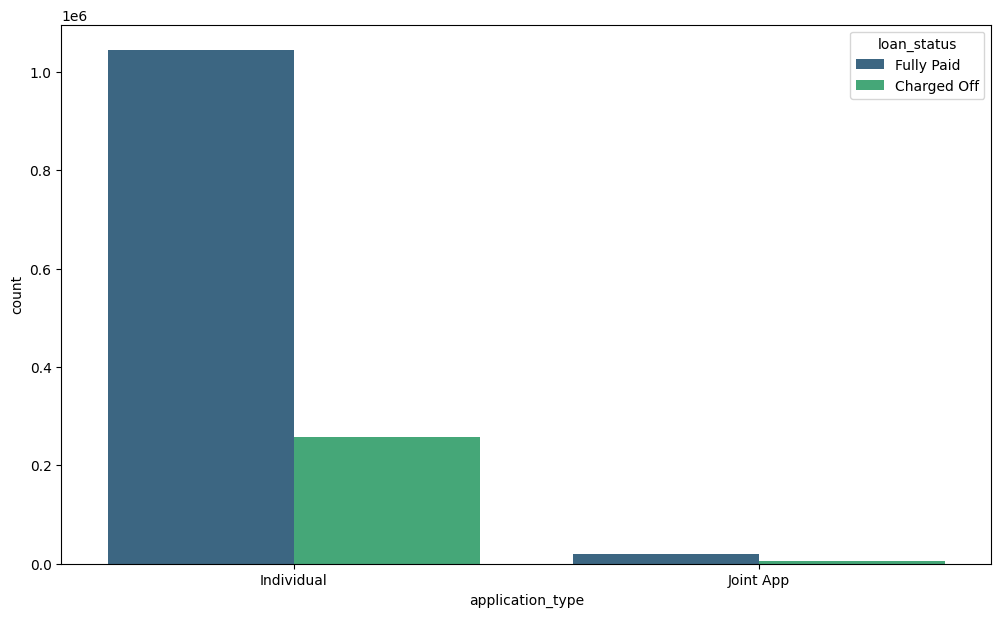

In [100]:
plt.figure(figsize=(12, 7))
sns.countplot(x='application_type', data=df_accepted,
              hue='loan_status', palette='viridis')

In [101]:
dummies_application_type = pd.get_dummies(
    df_accepted['application_type'], drop_first=True)
df_accepted = pd.concat([df_accepted.drop(
    'application_type', axis=1), dummies_application_type], axis=1)

### initial_list_status

In [102]:
df_accepted['initial_list_status'].value_counts()

initial_list_status
w    773136
f    554511
Name: count, dtype: int64

<Axes: xlabel='initial_list_status', ylabel='count'>

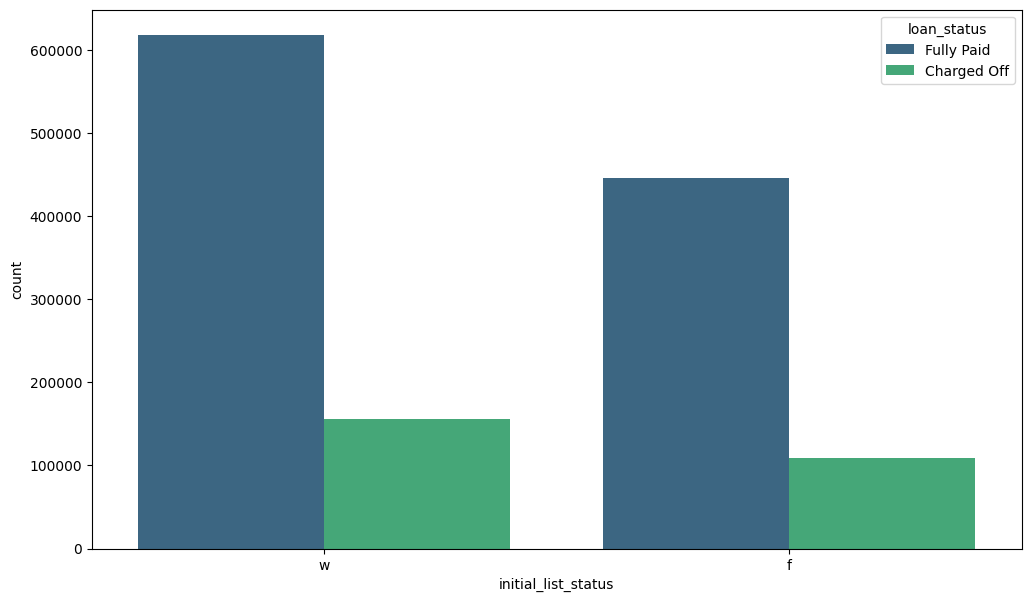

In [103]:
plt.figure(figsize=(12, 7))
sns.countplot(x='initial_list_status', data=df_accepted,
              hue='loan_status', palette='viridis')

In [104]:
df_accepted = df_accepted.drop('initial_list_status', axis=1)

### int_rate

In [105]:
df_accepted['int_rate'].head()

0    13.99
1    11.99
2    10.78
4    22.45
5    13.44
Name: int_rate, dtype: float64

In [106]:
df_accepted.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,264163.0,15.709986,4.898107,5.31,12.29,15.05,18.55,30.99
Fully Paid,1063484.0,12.635107,4.523703,5.31,9.17,12.29,15.31,30.99


### loan_amt



The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.


In [109]:
df_accepted['loan_amnt'].head()

0     3600.0
1    24700.0
2    20000.0
4    10400.0
5    11950.0
Name: loan_amnt, dtype: float64

In [110]:
df_accepted.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,264163.0,15498.128428,8745.867437,1000.0,9000.0,14175.0,20125.0,40000.0
Fully Paid,1063484.0,14011.935746,8571.013028,500.0,7450.0,12000.0,20000.0,40000.0


### total_acc

The total number of credit lines currently in the borrower's credit file

In [113]:
df_accepted['total_acc'].describe()

count    1.327647e+06
mean     2.492700e+01
std      1.196238e+01
min      2.000000e+00
25%      1.600000e+01
50%      2.300000e+01
75%      3.200000e+01
max      1.760000e+02
Name: total_acc, dtype: float64

C:\Users\Admin\AppData\Local\Temp\ipykernel_15960\3917649794.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_accepted, x='total_acc', palette='viridis')


<Axes: xlabel='total_acc', ylabel='count'>

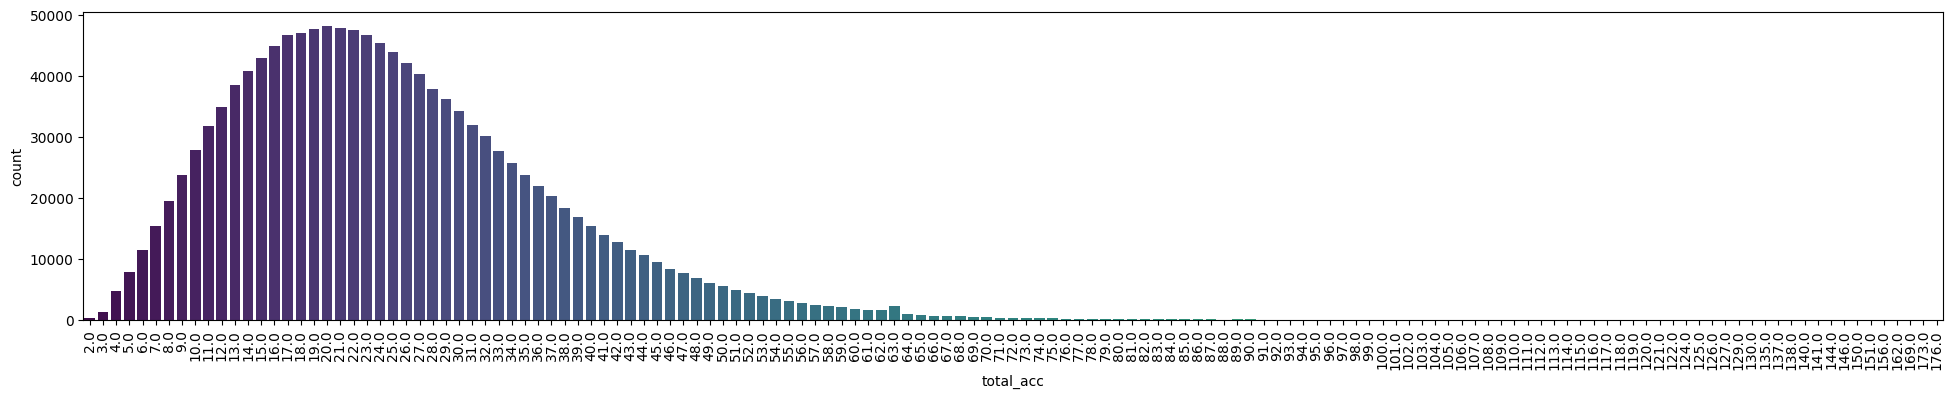

In [114]:
plt.figure(figsize=(24, 4))
plt.xticks(rotation=90)
sns.countplot(data=df_accepted, x='total_acc', palette='viridis')

Since there are some outliers, we will drop rows with customers with 'total_acc' > 63.

In [115]:
df_accepted = df_accepted[df_accepted['total_acc'] < 64]

C:\Users\Admin\AppData\Local\Temp\ipykernel_15960\3917649794.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_accepted, x='total_acc', palette='viridis')


<Axes: xlabel='total_acc', ylabel='count'>

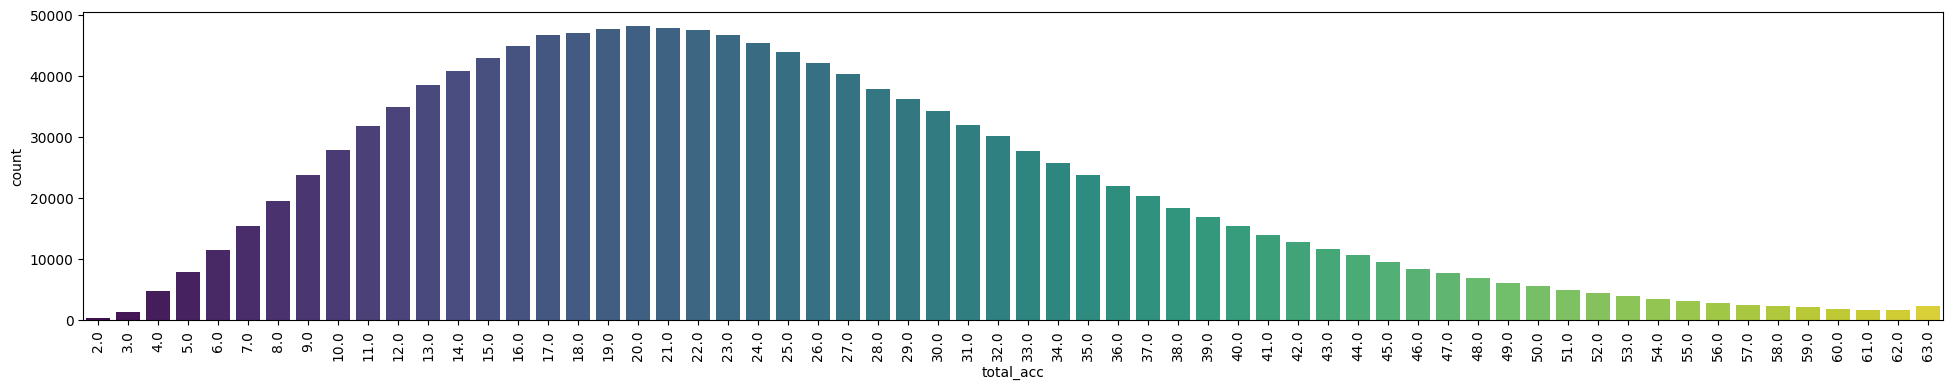

In [116]:
plt.figure(figsize=(24, 4))
plt.xticks(rotation=90)
sns.countplot(data=df_accepted, x='total_acc', palette='viridis')

<Axes: xlabel='total_acc', ylabel='count'>

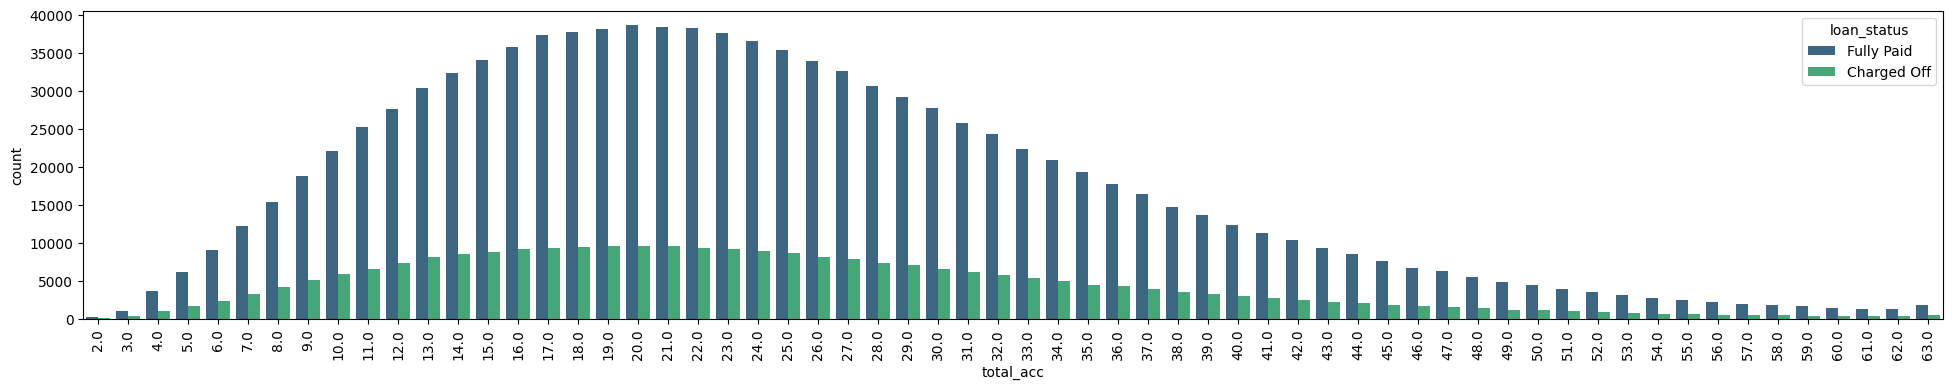

In [117]:
plt.figure(figsize=(24, 4))
plt.xticks(rotation=90)
sns.countplot(data=df_accepted, x='total_acc',
              hue='loan_status', palette='viridis')

Difference can be seen in the mean 'total_acc' between the two 'loan_status' categories. We will go ahead and keep this feature.

### open_acc

C:\Users\Admin\AppData\Local\Temp\ipykernel_15960\2270436934.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_accepted, x='open_acc', palette='viridis')


<Axes: xlabel='open_acc', ylabel='count'>

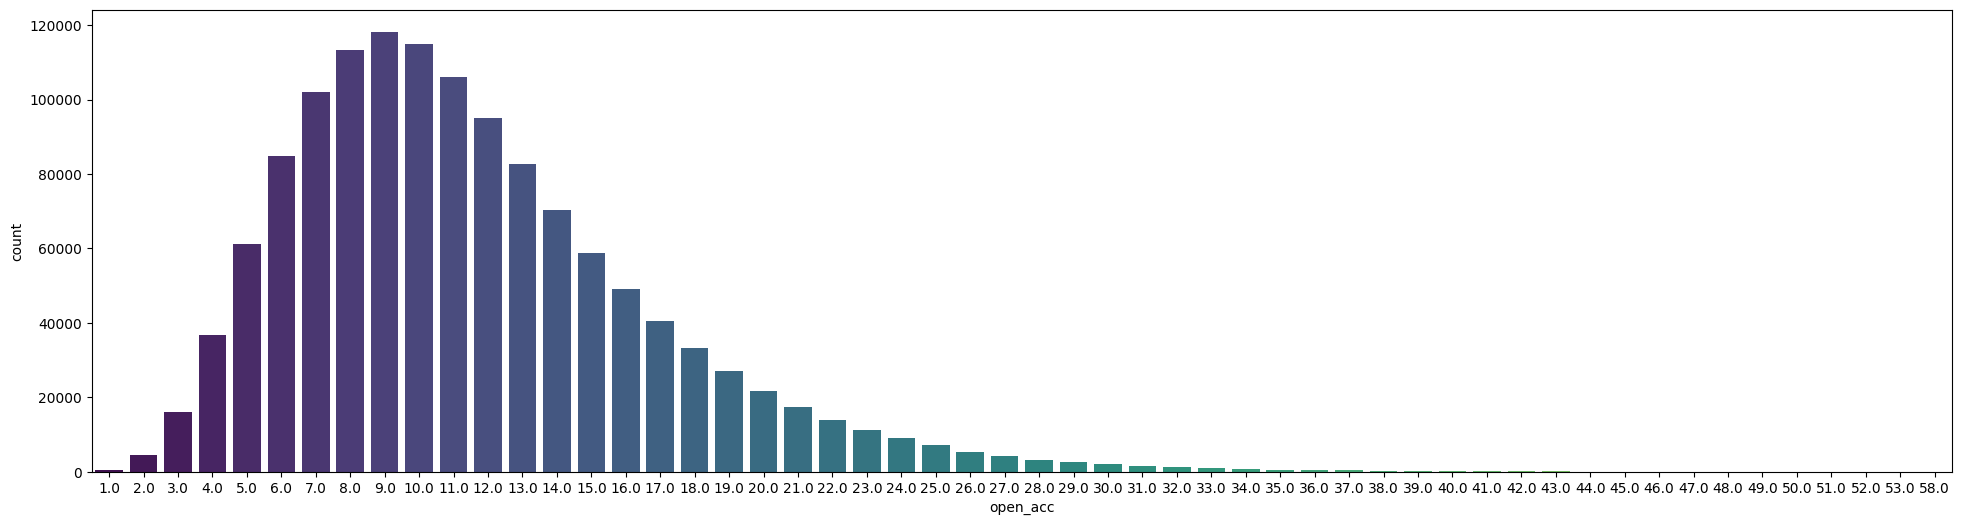

In [118]:
plt.figure(figsize=(24, 6))
sns.countplot(data=df_accepted, x='open_acc', palette='viridis')

<Axes: xlabel='open_acc', ylabel='count'>

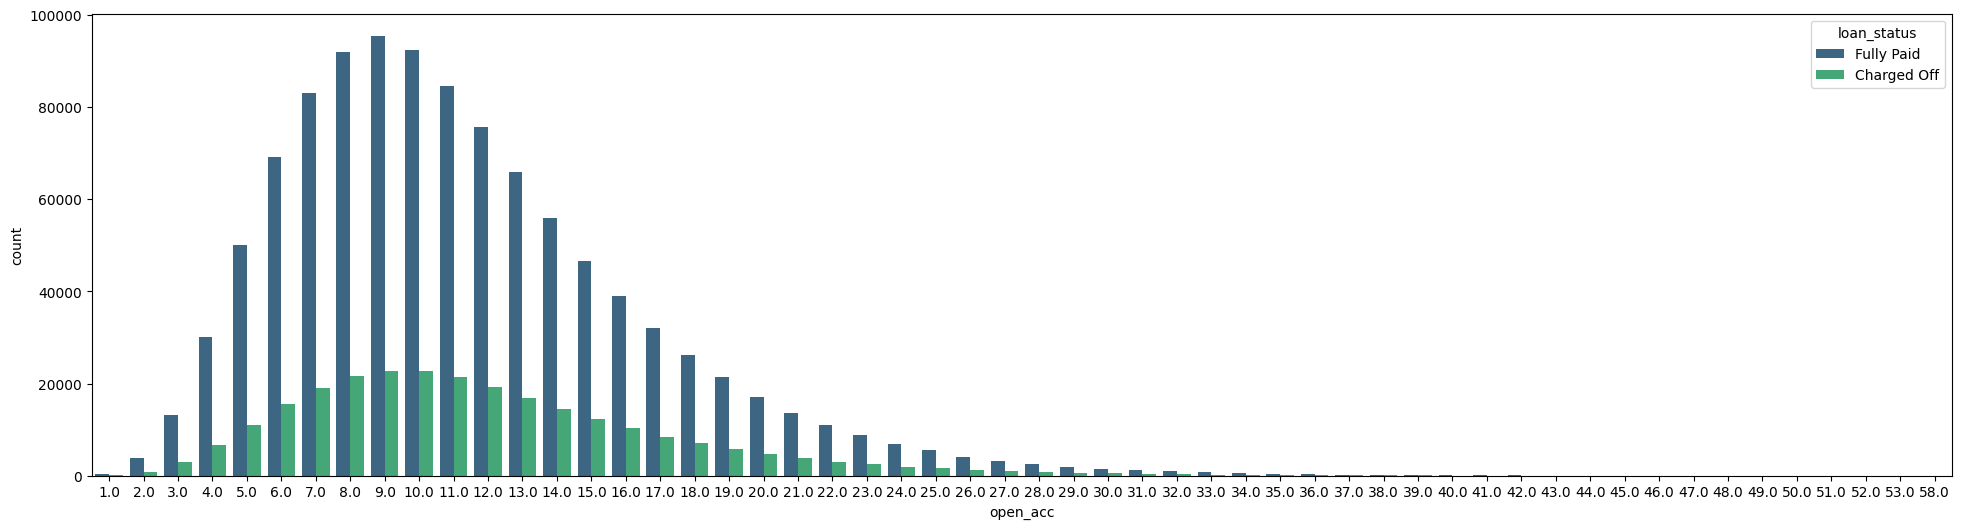

In [119]:
plt.figure(figsize=(24, 6))
sns.countplot(data=df_accepted, x='open_acc',
              hue='loan_status', palette='viridis')



Minute difference can be seen in the mean 'open_acc' between the two 'loan_status' categories. We will go ahead and keep this feature.


### pub_rec

C:\Users\Admin\AppData\Local\Temp\ipykernel_15960\325715522.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_accepted, x='pub_rec', palette='viridis')


<Axes: xlabel='pub_rec', ylabel='Count'>

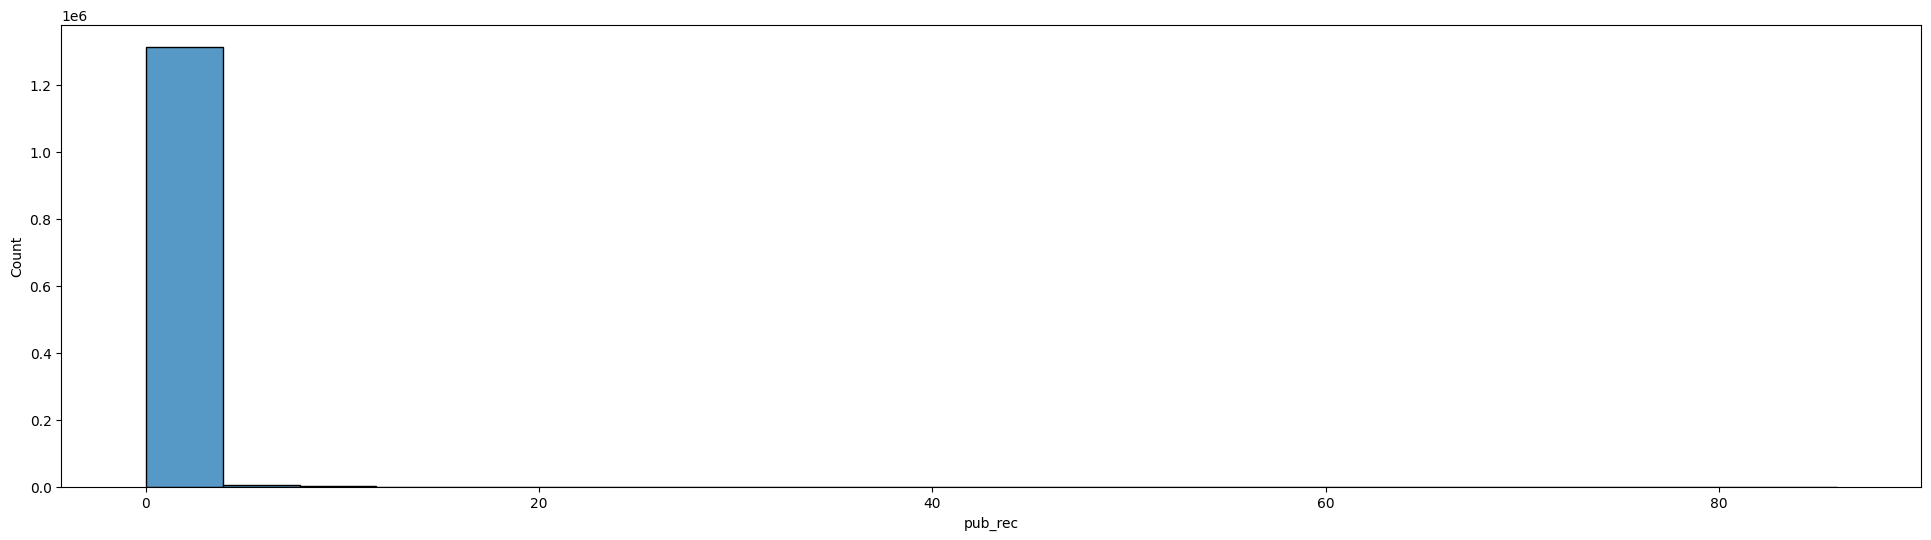

In [120]:
plt.figure(figsize=(24, 6))
sns.histplot(data=df_accepted, x='pub_rec', palette='viridis')

In [122]:
len(df_accepted[df_accepted['pub_rec'] > 2])*100/len(df_accepted)

0.9345546504551899

There are some outliers. Let's drop the rows with customers who have 'pub_rec > 2.

In [123]:
df_accepted = df_accepted[df_accepted['pub_rec'] < 3]

### pub_rec_bankruptcies



We will create a function to categorise 'annual_inc' in 5 categories and based on these categories, we will fill in the missing values of 'pub_rec_bankruptcies' by a group_by call.


In [125]:
def inc_cat(income):
    if income < 50000:
        return ('cat 1')
    if income >= 50000 and income < 100000:
        return ('cat 2')
    if income >= 100000 and income < 150000:
        return ('cat 3')
    if income >= 150000 and income < 200000:
        return ('cat 4')
    if income >= 200000:
        return ('cat 5')


df_accepted['annual_inc_categorised'] = df_accepted['annual_inc'].apply(
    inc_cat)  # make a new column in the df for categorised income

In [126]:
df_accepted[['annual_inc_categorised', 'annual_inc']]

,annual_inc_categorised,annual_inc
0,cat 2,55000.0
1,cat 2,65000.0
2,cat 2,63000.0
4,cat 3,104433.0
5,cat 1,34000.0
...,...,...
2260686,cat 3,119000.0
2260688,cat 3,130000.0
2260690,cat 4,180792.0
2260691,cat 4,157000.0




Let us now fill in the missing value by the mean value of 'pub_rec_bankruptcies' for the corresponding 'annual_inc_categorised' column.


In [127]:
df_accepted['pub_rec_bankruptcies'] = df_accepted['pub_rec_bankruptcies'].fillna(
    df_accepted.groupby('annual_inc_categorised')['pub_rec_bankruptcies'].transform('mean'))

In [128]:
df_accepted['pub_rec_bankruptcies'].isnull().sum()

0

Let's now drop the 'annual_inc_categorised' feature.

In [129]:
df_accepted = df_accepted.drop('annual_inc_categorised', axis=1)

### purpose

A category provided by the borrower for the loan request.

In [130]:
len(df_accepted['purpose'].unique())

14

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'debt_consolidation'),
  Text(1, 0, 'small_business'),
  Text(2, 0, 'home_improvement'),
  Text(3, 0, 'major_purchase'),
  Text(4, 0, 'credit_card'),
  Text(5, 0, 'other'),
  Text(6, 0, 'house'),
  Text(7, 0, 'vacation'),
  Text(8, 0, 'car'),
  Text(9, 0, 'medical'),
  Text(10, 0, 'moving'),
  Text(11, 0, 'renewable_energy'),
  Text(12, 0, 'wedding'),
  Text(13, 0, 'educational')])

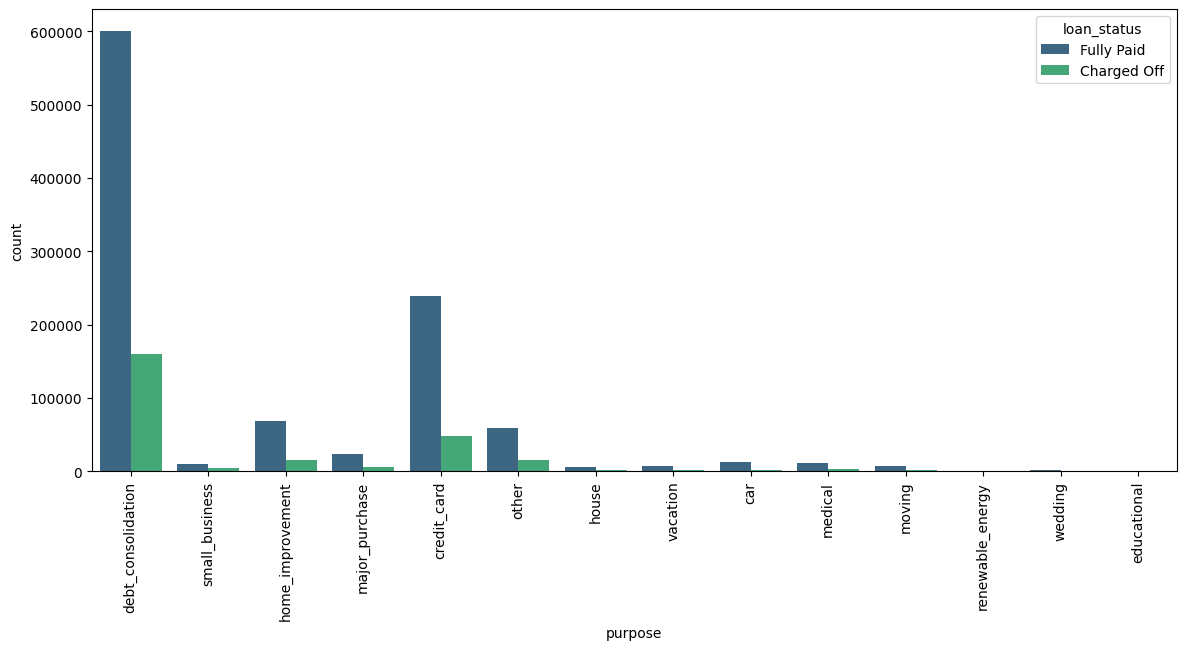

In [131]:


plt.figure(figsize=(14, 6))
sns.countplot(data=df_accepted, x='purpose',
              hue='loan_status', palette='viridis')
plt.xticks(rotation=90)

In [132]:
dummies_purpose = pd.get_dummies(df_accepted['purpose'], drop_first=True)

In [133]:
df_accepted = pd.concat(
    [df_accepted.drop('purpose', axis=1), dummies_purpose], axis=1)

In [139]:
df_accepted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1307227 entries, 0 to 2260697
Columns: 148 entries, id to wedding
dtypes: bool(101), float64(33), int64(1), int8(1), object(12)
memory usage: 595.9+ MB


### revol_bal

C:\Users\Admin\AppData\Local\Temp\ipykernel_15960\3983031149.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_accepted, y='loan_status',


<Axes: xlabel='revol_bal', ylabel='loan_status'>

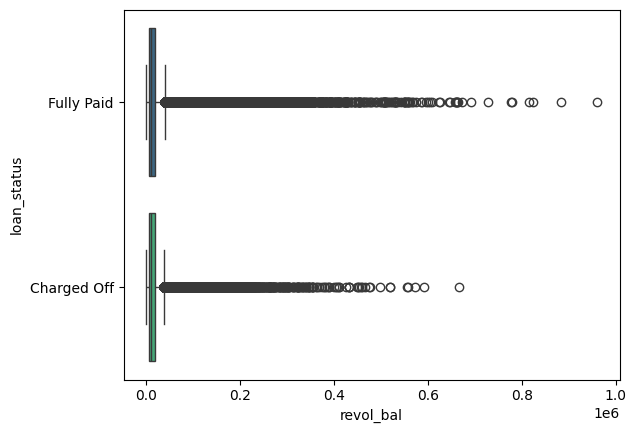

In [140]:
sns.boxplot(data=df_accepted, y='loan_status',
            x='revol_bal', palette='viridis')



There are some outliers. Let's first check how many rows are there with 'revol_bal' > $100000.


In [142]:
len(df_accepted[df_accepted['revol_bal'] > 100000]) * 100 / len(df_accepted)

0.7372858730733071

In [143]:
df_accepted = df_accepted[df_accepted['revol_bal'] < 100001]

C:\Users\Admin\AppData\Local\Temp\ipykernel_15960\3983031149.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_accepted, y='loan_status',


<Axes: xlabel='revol_bal', ylabel='loan_status'>

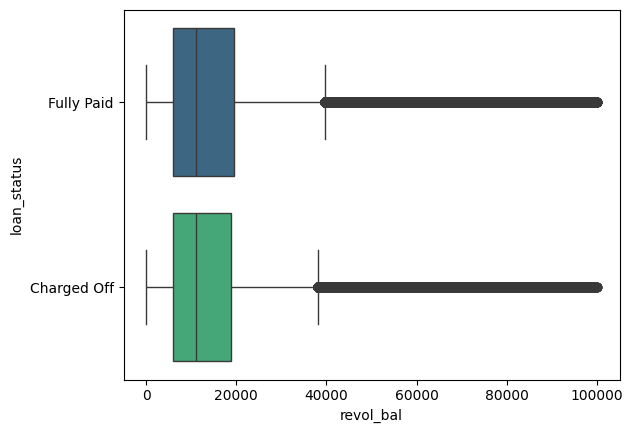

In [144]:
sns.boxplot(data=df_accepted, y='loan_status',
            x='revol_bal', palette='viridis')

### revol_util

In [145]:
df_accepted['revol_util'] = df_accepted['revol_util'].fillna(
    df_accepted['revol_util'].mean())

C:\Users\Admin\AppData\Local\Temp\ipykernel_15960\3623271339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accepted['revol_util'] = df_accepted['revol_util'].fillna(


In [146]:
df_accepted['revol_util'].isnull().sum()

0

C:\Users\Admin\AppData\Local\Temp\ipykernel_15960\1931561545.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_accepted, x='revol_util', bins=88, palette='viridis')


<Axes: xlabel='revol_util', ylabel='Count'>

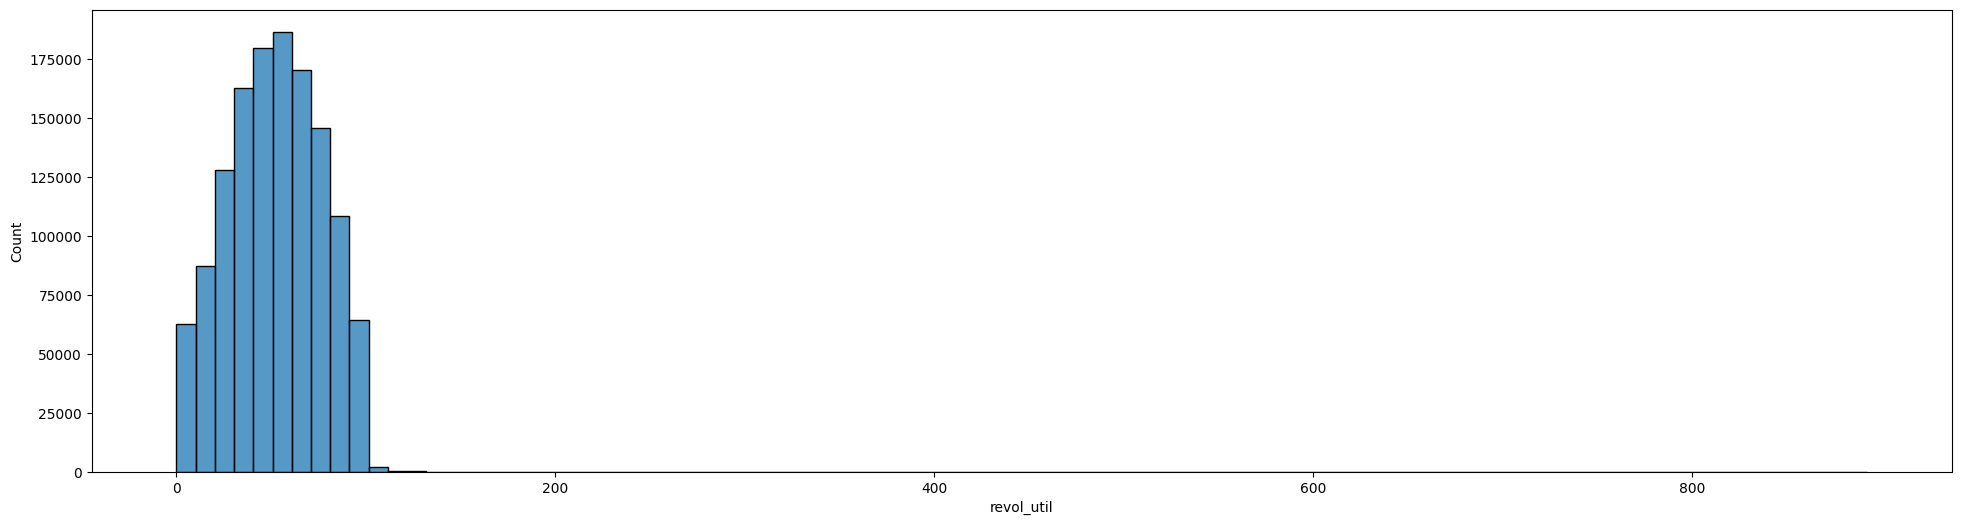

In [147]:
plt.figure(figsize=(24, 6))
sns.histplot(data=df_accepted, x='revol_util', bins=88, palette='viridis')

In [148]:
df_accepted = df_accepted[df_accepted['revol_util'] < 150]

C:\Users\Admin\AppData\Local\Temp\ipykernel_15960\1931561545.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_accepted, x='revol_util', bins=88, palette='viridis')


<Axes: xlabel='revol_util', ylabel='Count'>

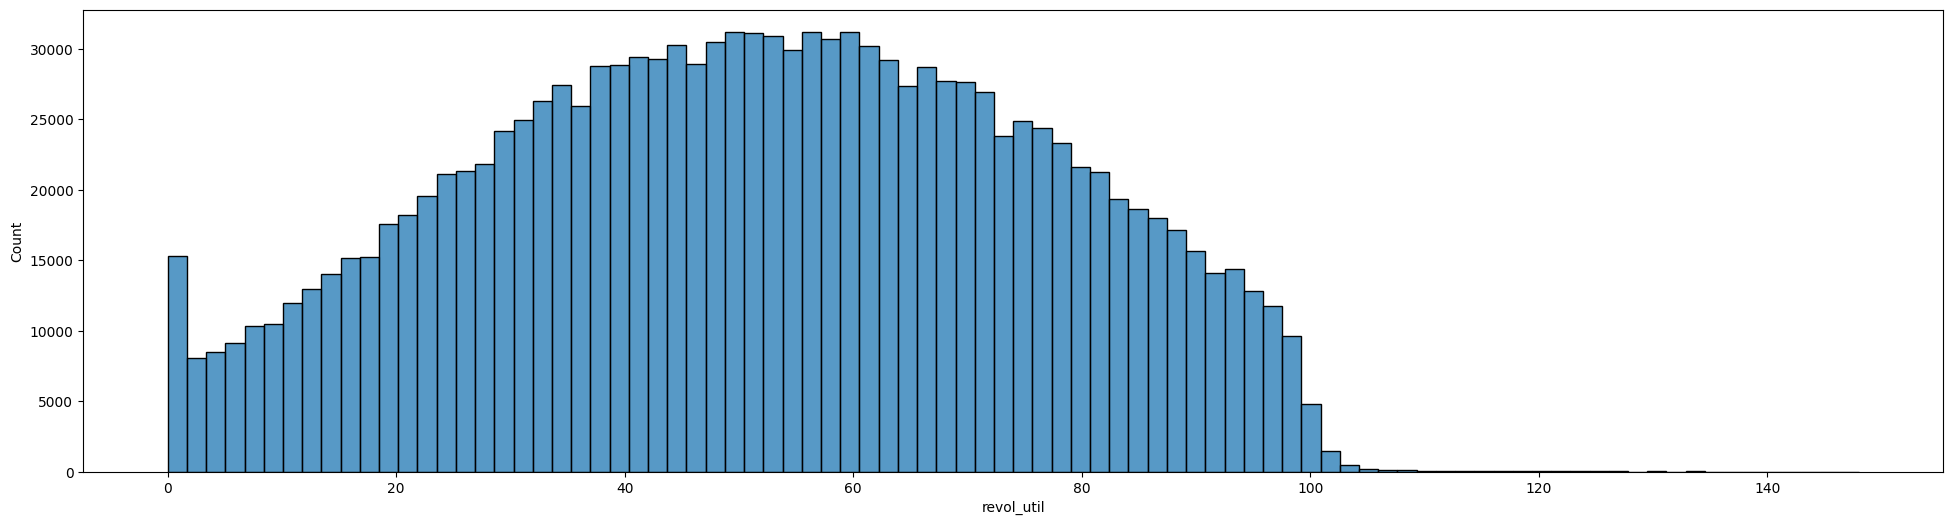

In [149]:
plt.figure(figsize=(24, 6))
sns.histplot(data=df_accepted, x='revol_util', bins=88, palette='viridis')

<Axes: xlabel='revol_util', ylabel='Count'>

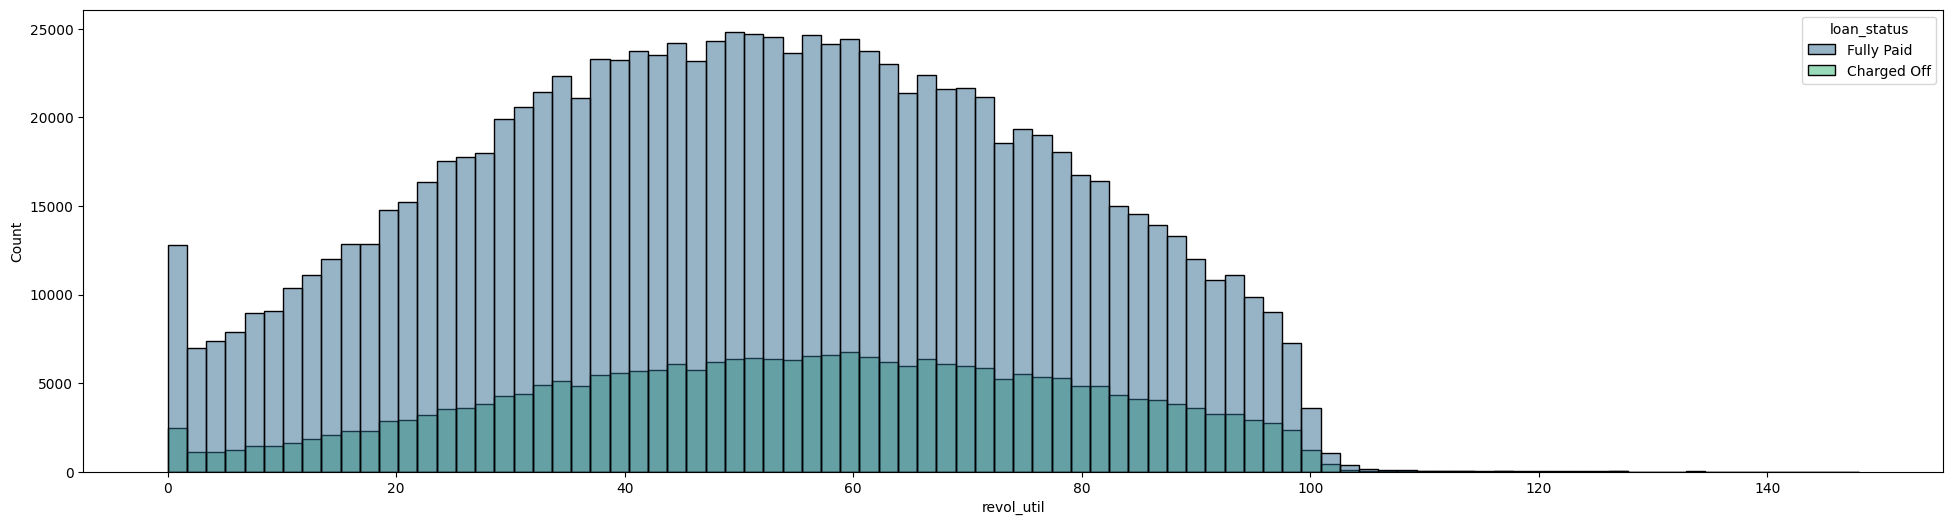

In [150]:
plt.figure(figsize=(24, 6))
sns.histplot(data=df_accepted, x='revol_util', bins=88,
             hue='loan_status', palette='viridis')

### verification_status

In [151]:
df_accepted['verification_status'].value_counts()

verification_status
Source Verified    499867
Verified           401087
Not Verified       396616
Name: count, dtype: int64

<Axes: xlabel='verification_status', ylabel='count'>

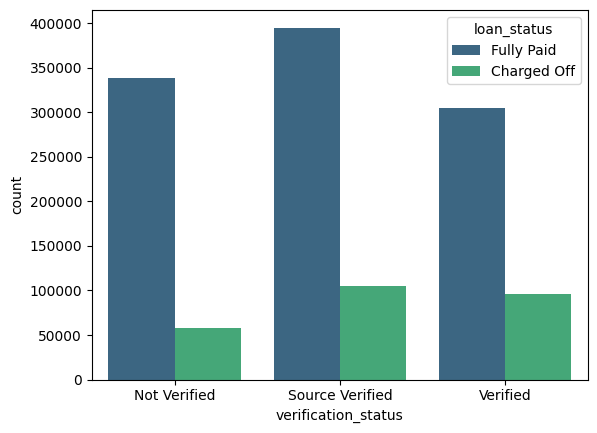

In [152]:
sns.countplot(data=df_accepted, x='verification_status',
              hue='loan_status', palette='viridis')

In [153]:
dummies_verification_status = pd.get_dummies(
    df_accepted['verification_status'], drop_first=True)
df_accepted = pd.concat([df_accepted.drop(
    'verification_status', axis=1), dummies_verification_status], axis=1)

In [159]:
df_cat = df_accepted.select_dtypes(include=['object'])
df_cat

,id,issue_d,loan_status,pymnt_plan,url,zip_code,last_pymnt_d,last_credit_pull_d,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,190xx,Jan-2019,Mar-2019,N,Cash,N
1,68355089,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,577xx,Jun-2016,Mar-2019,N,Cash,N
2,68341763,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,605xx,Jun-2017,Mar-2019,N,Cash,N
4,68476807,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,174xx,Jul-2016,Mar-2018,N,Cash,N
5,68426831,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,300xx,May-2017,May-2017,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...
2260684,89846605,Oct-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,802xx,May-2017,Jun-2018,N,Cash,N
2260685,89007204,Oct-2016,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,906xx,Jan-2017,May-2017,N,Cash,N
2260688,89905081,Oct-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,775xx,Aug-2018,Mar-2019,N,Cash,N
2260690,88948836,Oct-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,900xx,Jul-2018,Jul-2018,N,Cash,N


In [162]:
df_accepted = df_accepted.drop(
    df_accepted.select_dtypes(include='object'), axis=1)

In [163]:
df_accepted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1297570 entries, 0 to 2260697
Columns: 139 entries, loan_amnt to Verified
dtypes: bool(103), float64(34), int64(1), int8(1)
memory usage: 485.1 MB


In [168]:
def encode_booleans(df, target_dtype='float'):
    """
    Encodes boolean columns in a DataFrame to float (default) or int.

    Args:
        df: The pandas DataFrame to encode.
        target_dtype: The desired data type for encoded booleans ('float' or 'int').

    Returns:
        A new DataFrame with boolean columns encoded to the specified dtype.
    """
    if target_dtype not in ['float', 'int']:
        raise ValueError("target_dtype must be 'float' or 'int'")

    # Select boolean columns
    boolean_cols = df.select_dtypes(include='bool')

    # Encode booleans to the specified dtype
    if target_dtype == 'float':
        encoded_cols = boolean_cols.astype(float)
    else:
        encoded_cols = boolean_cols.astype(int)

    # Replace original boolean columns with encoded versions
    df = df.drop(boolean_cols.columns, axis=1)
    df = pd.concat([df, encoded_cols], axis=1)

    return df


# Example usage (encode to float)
df_encoded_float = encode_booleans(df_accepted.copy())
print(df_encoded_float)

         loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0           3600.0       3600.0           3600.0    36     13.99       123.03   
1          24700.0      24700.0          24700.0    36     11.99       820.28   
2          20000.0      20000.0          20000.0    60     10.78       432.66   
4          10400.0      10400.0          10400.0    60     22.45       289.91   
5          11950.0      11950.0          11950.0    36     13.44       405.18   
...            ...          ...              ...   ...       ...          ...   
2260684    15000.0      15000.0          15000.0    36     10.49       487.47   
2260685    36400.0      36400.0          36400.0    60     14.49       856.24   
2260688    18000.0      18000.0          18000.0    60      9.49       377.95   
2260690    29400.0      29400.0          29400.0    60     13.99       683.94   
2260697    24000.0      24000.0          24000.0    60     14.49       564.56   

         annual_inc  loan_s

In [170]:
df_encoded_float.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1297570 entries, 0 to 2260697
Columns: 139 entries, loan_amnt to Verified
dtypes: float64(137), int64(1), int8(1)
memory usage: 1.3 GB


In [171]:
df_encoded_float.drop(columns=['loan_status'])

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,earliest_cr_line,...,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Source Verified,Verified
0,3600.0,3600.0,3600.0,36,13.99,123.03,55000.0,5.91,0.0,2003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24700.0,24700.0,24700.0,36,11.99,820.28,65000.0,16.06,1.0,1999,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,20000.0,20000.0,20000.0,60,10.78,432.66,63000.0,10.78,0.0,2000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10400.0,10400.0,10400.0,60,22.45,289.91,104433.0,25.37,1.0,1998,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,11950.0,11950.0,11950.0,36,13.44,405.18,34000.0,10.20,0.0,1987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260684,15000.0,15000.0,15000.0,36,10.49,487.47,60000.0,26.40,0.0,1980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2260685,36400.0,36400.0,36400.0,60,14.49,856.24,95000.0,21.50,0.0,1987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2260688,18000.0,18000.0,18000.0,60,9.49,377.95,130000.0,20.59,0.0,2004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2260690,29400.0,29400.0,29400.0,60,13.99,683.94,180792.0,22.03,0.0,2002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [173]:
df_encoded_float.head

<bound method NDFrame.head of          loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0           3600.0       3600.0           3600.0    36     13.99       123.03   
1          24700.0      24700.0          24700.0    36     11.99       820.28   
2          20000.0      20000.0          20000.0    60     10.78       432.66   
4          10400.0      10400.0          10400.0    60     22.45       289.91   
5          11950.0      11950.0          11950.0    36     13.44       405.18   
...            ...          ...              ...   ...       ...          ...   
2260684    15000.0      15000.0          15000.0    36     10.49       487.47   
2260685    36400.0      36400.0          36400.0    60     14.49       856.24   
2260688    18000.0      18000.0          18000.0    60      9.49       377.95   
2260690    29400.0      29400.0          29400.0    60     13.99       683.94   
2260697    24000.0      24000.0          24000.0    60     14.49       564.56  

In [174]:
df_without_loan_status = df_encoded_float.drop('loan_status', axis=1)

In [175]:
df_without_loan_status.head

<bound method NDFrame.head of          loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0           3600.0       3600.0           3600.0    36     13.99       123.03   
1          24700.0      24700.0          24700.0    36     11.99       820.28   
2          20000.0      20000.0          20000.0    60     10.78       432.66   
4          10400.0      10400.0          10400.0    60     22.45       289.91   
5          11950.0      11950.0          11950.0    36     13.44       405.18   
...            ...          ...              ...   ...       ...          ...   
2260684    15000.0      15000.0          15000.0    36     10.49       487.47   
2260685    36400.0      36400.0          36400.0    60     14.49       856.24   
2260688    18000.0      18000.0          18000.0    60      9.49       377.95   
2260690    29400.0      29400.0          29400.0    60     13.99       683.94   
2260697    24000.0      24000.0          24000.0    60     14.49       564.56  

In [176]:
data_clean = df_without_loan_status.copy()

In [ ]:
data_clean.to_csv('data_clean.csv')